# **Maya Climate Coding Task**

### Task 1: Implement a Jupyter Notebook to visualise the extent of mangrove coverage within the AOI overthe five years. The analysis will primarily include:

● Mapping: To represent the mangrove distribution visually, use the
provided GMW TIFF file, cropped to the AOI bounds.

● Charting: Use Plotly to create dynamic charts showing changes in
mangrove coverage overtime, aligning with the data visualisation
tools used in our application front end.

Set up environment and import libraries

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install rasterio
! pip install rioxarray
! pip install contextily

In [5]:
import os
import glob
import rasterio as rio
import geopandas as gpd
from osgeo import gdal
import xarray as xr
import rioxarray
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import contextily as ctx

Import data for this case study

In [7]:
os.chdir("/content/drive/MyDrive/maya_geospatial_engineer_case_study/")
os.listdir()

['mangroves_case_study.geojson',
 'gmw_2020.tif',
 'gmw_2016.tif',
 'gmw_2018.tif',
 'gmw_2017.tif',
 'gmw_2019.tif',
 '__MACOSX',
 'dem_data.tif',
 'gmw_2016_aoi.tif',
 'gmw_2017_aoi.tif',
 'gmw_2018_aoi.tif',
 'gmw_2019_aoi.tif',
 'gmw_2020_aoi.tif']

### Preprocess geotiff files

As the mangrove watch data covers much larger area than our study site, let's do some preprocessing to clip the tiff file to focus on study site only. GDAL is used for this task.

In [8]:
# Define path to AOI GeoJSON file
aoi_file = "mangroves_case_study.geojson"

# Read area of interest
aoi_gdf = gpd.read_file(aoi_file)
aoi_geom = aoi_gdf.geometry.values[0]

In [ ]:
# Iterate over each year
for year in range(2016, 2021):
    # Define input and output file paths
    input_file = f"gmw_{year}.tif" # full coverage
    output_file = f"gmw_{year}_aoi.tif" # coverage of study site

    # Clip raster
    gdal.Warp(output_file, input_file, cutlineDSName=aoi_file, cutlineWhere=f"fid=0", cropToCutline=True)

    print(f"Clipping completed for {year}")

print("All years clipped successfully.")

Clipping completed for 2016
Clipping completed for 2017
Clipping completed for 2018
Clipping completed for 2019
Clipping completed for 2020
All years clipped successfully.


### Construct time series dataset for mangrove coverage

Now we have separate files for each year, making the comparison not as straight-forward. Let's construct a xarray dataset to align data from all years together.

In [79]:
# List of years
years = range(2016, 2021)

# List to store DataArrays for each year
data_arrays = []

# Iterate over each year
for year in years:
    # Load TIFF file for the current year
    file_path = f"gmw_{year}_aoi.tif"
    da = rioxarray.open_rasterio(file_path)

    # Add projection information
    da.rio.write_crs("epsg:4326", inplace=True)

    # Assign time dimension for the multiple years
    da = da.expand_dims(time=[year])

    # Append DataArrays
    data_arrays.append(da)

# Create the dataset for mangrove time series data
dataset = xr.concat(data_arrays, dim='time')
dataset = dataset.rename({'band': 'variable'})


Looking at the resulting xarray dataset, consisting 5 time steps with 1 variable.

In [7]:
dataset

<xarray.DataArray (time: 5, variable: 1, y: 454, x: 623)>
array([[[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]],


       [[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]],


       [[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
...
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]],


       [[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]],


       [[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]]], dtype=uint8)
Coordinates:
  * time         (time) int64 2016 2017 2018 2019 2020
  * variable     (variable) int64 1
  * x            (x) float64 0.6888 0.689 0.6892 0.6894 ... 0.8266 0.8268 0.827
  * y            (y) float64 5.875 5.874 5.874 5.874 ... 5.775 5.774 5.774 5.774
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     0
    scale_factor:   1.0
    add_offset:     0.0

## **Data Visualization**

Now, we need to visualize mangrove distribution at the study site for each year. We can do it directly with the xarray dataset. Contextily will be used to add a basemap into our data for more intuitive overview.

In [10]:
# Mask out data absence
dataset = dataset.where(dataset != 0, other=np.nan)

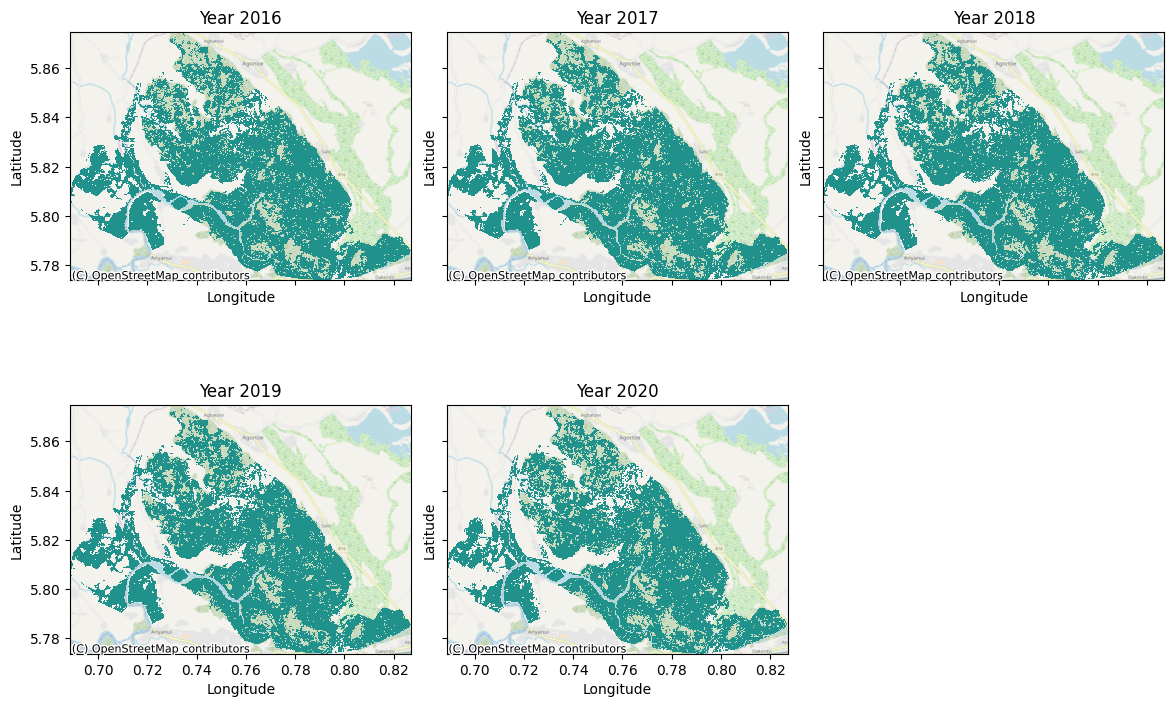

In [ ]:
# Plot the time series dataset
ax = dataset.plot(
    x="x", y="y",
    col="time", cmap='viridis',
    col_wrap=3, figsize=(12, 8),
    add_colorbar=False
    )

# Add contextily basemap to each subplot
titles = ['2016', '2017', '2018', '2019', '2020']

for title, axi in zip(titles, ax.axs.flat):
    ctx.add_basemap(axi, crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.8)
    axi.set_xlabel("Longitude")
    axi.set_ylabel("Latitude")
    axi.set_title(f"Year {title}")

plt.show()

### Combining Time Series Data

To make it easier to compare each pixel, we can integrate all years togehter. Using a mean filter, we compress the time series data into a layer of mangrove occurence (0: absence in all years, 1: presence in all years).

Now we can tell the uncertainty presents mostly close to the river bed and at the edges of the patches.

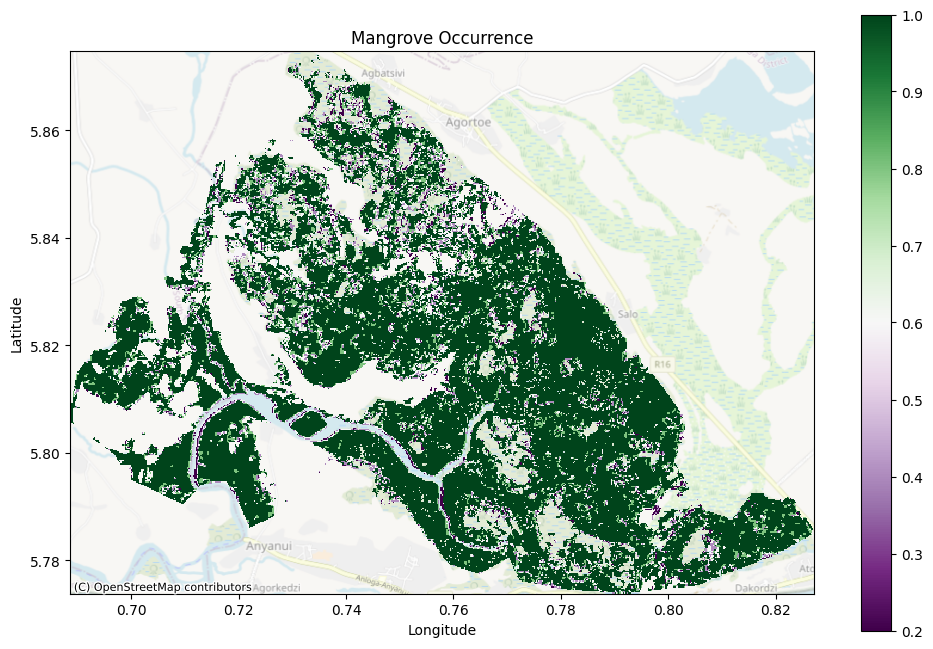

In [ ]:
fig = dataset.mean(dim="time").where(dataset.mean(dim="time") > 0, other=np.nan).plot(
      x="x", y="y", cmap='PRGn',
      figsize=(12, 8),
    )

ax = fig.axes
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.5)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title(f"Mangrove Occurrence")
plt.show()

## Visualizing Time Series Changes of Mangrove Coverage

To visualize the changes, let's compute the area coverage by the mangroves. Then we can plot data for each year into a bar chart using Plotly. We can tell the range first increases for two years following by a slight drop.

In [41]:
# Calculate the area of each pixel
pixel_area = 25 * 25 * 0.001 * 0.001  # in square kilometers

# Calculate the sum of pixel values multiplied by the pixel area
coverage = (dataset * pixel_area).sum(dim=('x', 'y'))

In [27]:
# Construct a dataset for coverage information each year
timestamp = coverage.time.values
area = coverage.variable.values.flatten()

df = pd.DataFrame({'Year': timestamp,
                   'Area': area})

# Visualizing results in a dynamic bar chart using plotly
fig = px.bar(
    df,
    x='Year',
    y='Area',
    labels={'Year': 'Year', 'Area': 'Area Covered by Mangrove (km²)'},
    hover_data={'Area':':.2f'}
    )

fig.update_xaxes(title_text='Year')
fig.update_yaxes(title_text='Mangrove Coverage (km²)')
fig.update_traces(width=0.5)

fig.show()

## **Documentation: Analysis Result**

The analysis of mangrove coverage within the designated site reveals notable fluctuations over the period under examination. Between 2016 and 2018, there was a clear increase in mangrove coverage, expanding from approximately 55.8 km2 to 57.4 km2. However, this growth trend was subsequently reversed, with a decline observed between 2018 and 2020, culminating in a total coverage of 54.8 km2.

The areas of notable change predominantly locates in the northern part of the site, particularly along the edges of existing mangrove clusters and adjacent to the riverbed.

<br>

### **Task 2: Coastal Flood Risk Assessment**

Now, we can look into the flood risk for the mangrove forest. To do so, we need to import another dataset indicating elevation profile. We will use NASADEM for this task, as it provides enhanced results compared to SRTM and also used for commercial product such as CoastelDEM, revealing its credibility for coastal application. The dataset is downloaded via Google Earth Engine for the study site.

Elevation Data Import

In [20]:
# NASADEM: https://developers.google.com/earth-engine/datasets/catalog/NASA_NASADEM_HGT_001
# Digital Elevation Model with improved accuracy sourced from SRTM

dem = rioxarray.open_rasterio("dem_data.tif")
dem = dem.where(dem>=-10, np.nan)

# Check on elevation profile of the study site
print(dem.min(), dem.max())

<xarray.DataArray ()>
array(-10.)
Coordinates:
    spatial_ref  int64 0 <xarray.DataArray ()>
array(49.)
Coordinates:
    spatial_ref  int64 0


In [ ]:
dem

<xarray.DataArray (band: 1, y: 376, x: 515)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 0.6887 0.689 0.6892 0.6895 ... 0.8267 0.8269 0.8272
  * y            (y) float64 5.875 5.875 5.874 5.874 ... 5.775 5.774 5.774 5.774
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -9999
    scale_factor:   1.0
    add_offset:     0.0

To examine the flood risk, we need to input the dem into a flood fill algorithms. The following function is adopted from online resources. It takes a starting point, checking the elevation of the neighbor pixels, creasting a flooded profile by iteration.

We defined our starting point by examining the [flow accumulation](https://developers.google.com/earth-engine/datasets/catalog/MERIT_Hydro_v1_0_1) from MERIT Hydro dataset, with the highest values representing most downstream pixels.

In [ ]:
def flood_fill(dem, lat, lon, height):
    """
    Assess flooding risk from a starting point (specified by latitude and longitude)
    with a given rise in water level (height) using a flood fill algorithm.

    Parameters:
        dem (xarray.Dataset): Digital Elevation Model dataset.
        lat (float): Latitude of the starting point.
        lon (float): Longitude of the starting point.
        height (float): Rise in water level at the starting point.

    Returns:
        np.ndarray: Array indicating areas at risk of flooding (1 for flooded, 0 for dry).
    """
    # Convert latitude and longitude to indices
    x_index = np.searchsorted(dem.x.values, longitude)
    y_index = np.abs(dem.y.values - latitude).argmin()
    # print(x_index, y_index)

    # Initialize flood fill
    filled = set()
    fill = set()
    fill.add((x_index, y_index))

    # Initialize flood array
    flood = np.zeros_like(dem.values, dtype=np.int8)

    # Loop through and modify the cells which need to be checked
    while fill:
        # Grab a cell
        x, y = fill.pop()

        # Check if the cell is within bounds
        if y >= 0 and y < dem.shape[1] and x >= 0 and x < dem.shape[2]:
            # Check if the cell is below the water level
            if dem.values[0, y, x] <= height:
                flood[0, y, x] = 1

                # Check neighbors for flooding
                neighbors = [(x-1, y), (x+1, y), (x, y-1), (x, y+1)]
                for neighbor_x, neighbor_y in neighbors:
                    if (neighbor_x, neighbor_y) not in filled:
                        fill.add((neighbor_x, neighbor_y))
                        filled.add((neighbor_x, neighbor_y))

    return flood

# seed point at the river body with the lowest elevation
longitude = 0.71136
latitude = 5.7945
height = 1 # assuming 1 m sea level rise

# Apply flood fill algorithm to DEM data
fld = flood_fill(dem, longitude, latitude, height)

In [22]:
def data_mask(ds, mask):
    """
    Apply binary flood mask to mangrove data array.

    Parameters:
        ds (xarray.DataArray): Data array to be masked.
        mask (xarray.DataArray): Binary mask.

    Returns:
        xarray.DataArray: Masked dataset.
    """
    dataset_high_res_interp = ds.interp_like(mask)
    masked_dataset = dataset_high_res_interp.where(mask)

    return masked_dataset

### Visualizing Mangrove Occurence

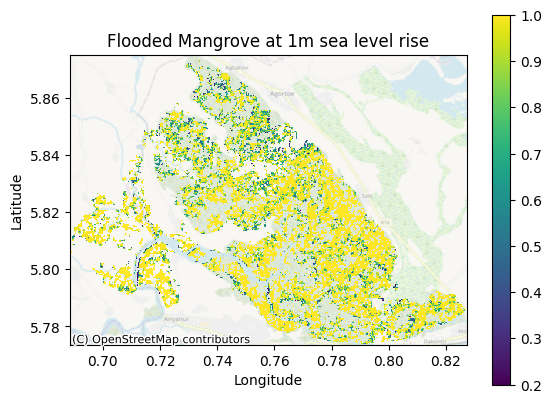

In [81]:
# Combine time series data into a single layer of occurence
mangrove_occurence = dataset.mean(dim="time")
masked_occurence = mangrove_occurence.where(dataset.mean(dim="time") > 0, other=np.nan)

# Create a new DataArray from the NumPy array with the same coordinates
flood_ds = xr.DataArray(fld, coords=dem.coords)
flood_masked = data_mask(masked_occurence, flood_ds)

# Visualizing flooded mangroves at the sea level rise scenario
fig = flood_masked.plot()
ax = fig.axes
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.5)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title(f"Flooded Mangrove at 1m sea level rise")
plt.show()

Let's resample the flooded dataset, so that it aligns well with our mangrove data.

In [60]:
flood_ds_resampled = flood_ds.interp_like(dataset)
flood_mask = flood_ds_resampled == 1

flood_ds_resampled

<xarray.DataArray (band: 1, y: 454, x: 623)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * band         (band) int64 1
    spatial_ref  int64 0
  * x            (x) float64 0.6888 0.689 0.6892 0.6894 ... 0.8266 0.8268 0.827
  * y            (y) float64 5.875 5.874 5.874 5.874 ... 5.775 5.774 5.774 5.774

Let's use flooded dataset to determine where the mangrove will be flooded with potential sea level rise.

In [63]:
# Calculate area of vulnerable and non-vulnerable pixels for each year
dataset_bool = dataset == 1
flood_mask = flood_ds_resampled == 1
flood_mask = flood_mask.rename({'band': 'variable'})
broadcasted_flood_mask = flood_mask.broadcast_like(dataset)

broadcasted_flood_mask

<xarray.DataArray (time: 5, variable: 1, y: 454, x: 623)>
array([[[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]],


       [[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]],


       [[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
...
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]],


       [[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]],


       [[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]]])
Coordinates:
  * variable     (variable) int64 1
    spatial_ref  int64 0
  * x            (x) float64 0.6888 0.689 0.6892 0.6894 ... 0.8266 0.8268 0.827
  * y            (y) float64 5.875 5.874 5.874 5.874 ... 5.775 5.774 5.774 5.774
  * time         (time) int64 2016 2017 2018 2019 2020

### Classification of Mangrove Vulnerability

Afterwards, we can classify mangrove vulnerability to sea level rise. The assessment is applied to the time series dataset.

In [65]:
assert broadcasted_flood_mask.values.shape == dataset.values.shape

In [66]:
# Mask the dataset with the flood mask
masked_dataset = xr.where(broadcasted_flood_mask & dataset_bool, 1, 0)

total_area = np.sum(dataset.where(dataset != 0, other=np.nan), axis=(1, 2, 3)) * pixel_area
vulnerable_area = np.sum(masked_dataset, axis=(1, 2, 3)) * pixel_area
non_vulnerable_area = total_area - vulnerable_area

print(vulnerable_area.values)
print(non_vulnerable_area.values)

[27.215625 27.741875 28.090625 27.6975   26.76875 ]
[28.585    28.95875  29.349375 28.98625  27.99    ]


### Visualizing Risk Assessment

In [73]:
# Adjust years to be from 2016 to 2020
years = np.arange(2016, 2021)

# Create Plotly stacked bar chart
fig = go.Figure()

fig.add_trace(go.Bar(name='Non-Vulnerable', x=years, y=non_vulnerable_area, marker_color='royalblue'))
fig.add_trace(go.Bar(name='Vulnerable', x=years, y=vulnerable_area, marker_color='crimson', base=non_vulnerable_area))

# Update the layout
fig.update_layout(
    title='Mangrove Risk Assessment (1 m sea level rise)',
    xaxis=dict(title='Year'),
    yaxis=dict(title='Area (km²)'),
    barmode='relative',  # Use relative barmode for stacking
    legend=dict(title='Category', orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1)
)

fig.update_traces(width=0.5)
fig.show()
